In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [10]:
url_features_fullfin='https://raw.githubusercontent.com/BenjaminIrarrazabal/Datos-Supernovas-Pruebas/main/features_fullfin.csv'
features_full = pd.read_csv(url_features_fullfin, index_col=None)
features_full

,oid,delta_mag_fid_1,positive_fraction_1,delta_mag_fid_2,positive_fraction_2,Multiband_period,PPE,Period_band_1,delta_period_1,Period_band_2,delta_period_2,MHPS_ratio_1,MHPS_low_1,MHPS_high_1,MHPS_ratio_2,MHPS_low_2,MHPS_high_2,GP_DRW_sigma_1,GP_DRW_tau_1,GP_DRW_sigma_2,GP_DRW_tau_2,Psi_CS_1,Psi_eta_1,Psi_CS_2,Psi_eta_2,Harmonics_mag_1_1,Harmonics_mag_2_1,Harmonics_mag_3_1,Harmonics_mag_4_1,Harmonics_mag_5_1,Harmonics_mag_6_1,Harmonics_mag_7_1,Harmonics_phase_2_1,Harmonics_phase_3_1,Harmonics_phase_4_1,Harmonics_phase_5_1,Harmonics_phase_6_1,Harmonics_phase_7_1,Harmonics_mse_1,Harmonics_mag_1_2,...,IAR_phi_1,LinearTrend_1,Amplitude_2,AndersonDarling_2,Autocor_length_2,Beyond1Std_2,Con_2,Gskew_2,Meanvariance_2,MedianAbsDev_2,MedianBRP_2,PairSlopeTrend_2,PercentAmplitude_2,Q31_2,Rcs_2,Skew_2,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2,SPM_A_1,SPM_t0_1,SPM_gamma_1,SPM_beta_1,SPM_tau_rise_1,SPM_tau_fall_1,SPM_chi_1,SPM_A_2,SPM_t0_2,SPM_gamma_2,SPM_beta_2,SPM_tau_rise_2,SPM_tau_fall_2,SPM_chi_2,classALeRCE
0,ZTF17aadlxmv,2.244800,1.0,1.847730,1.0,51.630429,0.018797,0.200240,51.430189,0.069774,51.560655,24.510580,3.971278,0.162023,26.178661,1.065202,0.040690,0.623412,11.018541,2.974256e-01,12.709005,0.441628,0.342535,0.361719,0.345065,5.176898e+01,2.247800e+01,16.378288,8.031787,35.167310,45.593497,65.823023,2.799746,3.812070,4.416340,3.855748,0.801975,3.920080,4.069061e-24,0.740893,...,0.903700,0.019445,0.923865,0.999412,3.0,0.222222,0.0,0.511683,0.025176,0.346074,0.388889,-0.500000,0.063359,0.657760,0.361719,0.767211,1.142780,0.466788,0.893531,1.000000,0.000594,1.874733,0.348850,0.838971,0.001989,0.339168,5.039542,21.779838,0.642127,2.329821,11.688850,0.007554,0.311686,6.958042,21.231870,0.416775,3.677212,30.091575,0.594409,SNIa
1,ZTF18aaaqexr,0.896138,1.0,0.191736,1.0,29.230770,0.000933,29.230770,0.000000,NaN,NaN,0.216739,0.046887,0.216330,NaN,NaN,NaN,0.062597,5.697961,5.886294e-07,0.983179,0.429391,1.045772,NaN,NaN,5.805312e+00,2.222749e+00,2.623629,1.479667,2.946373,2.618439,1.582411,2.209948,3.903036,1.966469,0.564790,3.835875,0.632893,1.865218e-28,2.142465,...,0.841811,0.026267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.198096,0.504445,2.074475,0.112886,1.205329,17.585409,0.281999,0.292699,-8.394195,9.801748,0.447687,8.599671,32.414657,NaN,SNIa
2,ZTF18aacdbzx,0.495977,1.0,0.786995,1.0,0.156563,0.004384,0.165508,0.008945,0.185710,0.029147,0.752135,0.016245,0.021599,8.221117,0.073785,0.008975,0.012080,1.541608,7.029221e-02,15.265901,0.366780,1.010175,0.364474,0.463809,3.731002e+00,1.030580e+00,4.626807,2.398018,2.417238,1.966842,6.632274,5.789298,4.023447,2.294776,3.697512,4.121476,5.312111,1.992437e-28,621.990994,...,0.799329,0.011157,0.393497,0.999341,2.0,0.100000,0.0,0.379781,0.011028,0.105004,0.200000,-0.366667,0.030335,0.257782,0.381896,1.301440,2.497958,0.212669,0.743787,0.999385,0.000068,6.512830,0.948480,0.924340,0.017806,0.183777,-7.254930,1.000737,0.333585,3.344743,24.821414,0.033287,0.114159,-5.114678,13.845587,0.063725,10.514456,20.820922,0.044529,SNIbc
3,ZTF18aadmssd,3.293953,1.0,2.170098,1.0,1.005344,0.056145,0.065053,0.940291,999.999953,998.994608,337.794556,34.621597,0.102493,342.520355,12.741676,0.037200,2.073645,117.090145,9.575899e-01,191.232153,0.434424,0.953035,0.270602,0.644786,7.272322e+00,2.503748e+00,2.237135,0.544766,3.829564,2.494791,5.496666,0.629241,1.759490,5.585220,4.970962,4.485922,2.156395,5.062500e-12,524.937163,...,0.986739,0.053669,1.085049,0.990112,6.0,0.200000,0.0,-0.184004,0.037748,0.418592,0.466667,-0.100000,0.066553,0.901432,0.403816,-0.066124,-0.621467,0.662524,0.917680,1.000000,0.001411,8.845398,0.926170,0.988949,0.027800,1.462569,-20.995965,28.830318,0.763144,2.939169,22.204705,0.010855,2.067952,-22.606536,39.255644,0.755130,17.087420,46.760686,1.111489,SNIIn
4,ZTF18aadzfso,1.371363,1.0,0.797367,1.0,1.028361,0.034737,1.029866,0.001505,37.037036,36.008675,0.751511,0.199288

In [11]:
count_clase1 = pd.DataFrame({'classALeRCE':features_full['classALeRCE']})
count_clase1.groupby(count_clase1.columns.tolist(),as_index=False).size()

,classALeRCE,size
0,SLSN,34
1,SNII,330
2,SNIIb,16
3,SNIIn,42
4,SNIa,1540
5,SNIbc,106


In [12]:
features_full['classALeRCE']= features_full['classALeRCE'].replace(['SNIIb','SNIIn'],'SNII')

In [13]:
cols = features_full.shape[1]
features_full = features_full.dropna(thresh=cols)

In [14]:
count_clase1 = pd.DataFrame({'classALeRCE':features_full['classALeRCE']})
count_clase1.groupby(count_clase1.columns.tolist(),as_index=False).size()

,classALeRCE,size
0,SLSN,33
1,SNII,329
2,SNIa,1166
3,SNIbc,76


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (1166) in class 2 will be larger than the number of samples in the majority class (class #2 -> 816)
  f"After over-sampling, the number of samples ({n_samples})"


MÉTRICAS CON DATOS DESBALANCEADOS
Classification accuracy is 42.572150 %
Classification precision is 42.530398 %
Classification recall is 42.572150 %
MÉTRICAS CON DATOS BALANCEADOS
Classification accuracy is 50.113683 %
Classification precision is 59.276207 %
Classification recall is 50.113683 %


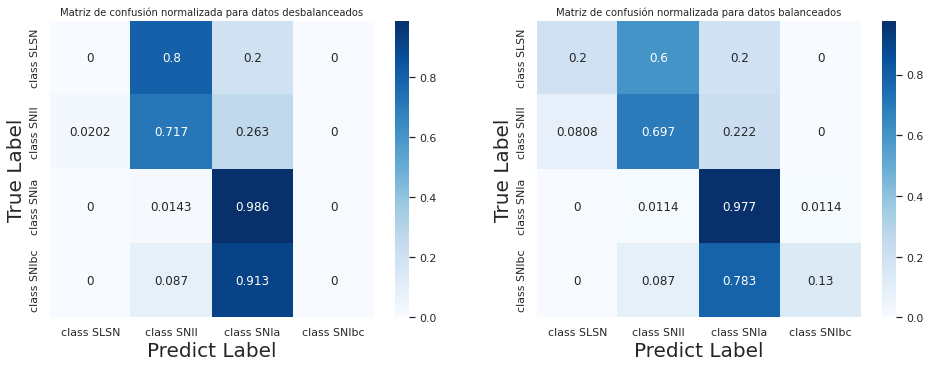

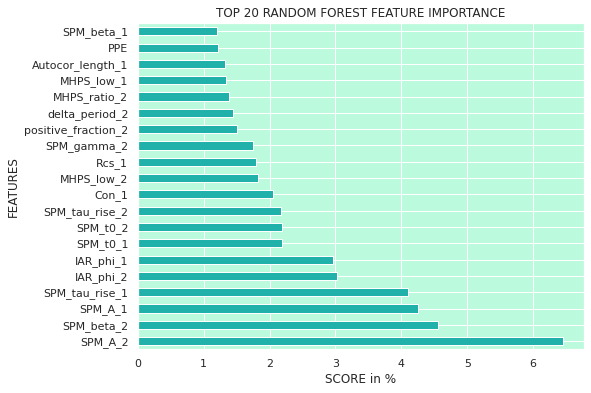

In [24]:
# SEPARAMOS LOS CONJUNTOS DE ENTRENAMIENTO Y VALIDACIÓN
le = LabelEncoder()
X = features_full.iloc[:,1:-1]
Y = features_full['classALeRCE']
Y = le.fit_transform(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, stratify=Y)
# NORMALIZAMOS LOS DATOS
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform (X_test)
# CLASIFICADOR PARA DATOS DESBALANCEADOS
classifier_1 = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=30,
    max_features='sqrt',
    n_jobs=-1,
    class_weight='balanced'
)
# SE REALIZA LA CLASIFICACIÓN
classifier_1.fit(X_train,Y_train)
Y_pred = classifier_1.predict(X_test)
# SE CALCULAN LAS MÉTRICAS DE DESEMPEÑO
accuracy_1= metrics.balanced_accuracy_score(Y_test, Y_pred)*100
presicion_1 = metrics.precision_score(Y_test, Y_pred,average='macro')*100
recall_1 = metrics.recall_score(Y_test, Y_pred,average='macro')*100
print('MÉTRICAS CON DATOS DESBALANCEADOS')
print("Classification accuracy is %2f"%accuracy_1,"%")
print("Classification precision is %2f"%presicion_1,"%")
print("Classification recall is %2f"%recall_1,"%")


# Ahora, que sucede con datos balanceados...

# transform the dataset
# OVERSAMPLING DE LA CLASE MINORITARIA
oversample1 = SMOTE(sampling_strategy = {0:660,1:658,2:1166,3:760}) 
X1_train_smote, y1_train_smote = oversample1.fit_resample(X_train, Y_train)
# CLASIFICADOR
classifier11 = RandomForestClassifier(
    n_estimators=200,
    criterion='gini',
    max_depth=100,
    max_features=15,
    n_jobs=-1,
    class_weight='balanced'
)
# ENTRENAMIENTO
classifier11.fit(X1_train_smote,y1_train_smote)

# SE PRUEBA EL CLASIFICADOR

pred_labels11 = classifier11.predict(X_test)

# MÉTRICAS DE DESEMPEÑO PARA EL CONJUNTO BALANCEADO

accuracy11= metrics.balanced_accuracy_score(Y_test, pred_labels11)*100
presicion11= metrics.precision_score(Y_test, pred_labels11,average='macro')*100
recall11 = metrics.recall_score(Y_test, pred_labels11,average='macro')*100
print('MÉTRICAS CON DATOS BALANCEADOS')
print("Classification accuracy is %2f"%accuracy11,"%")
print("Classification precision is %2f"%presicion11,"%")
print("Classification recall is %2f"%recall11,"%")

# FIGURAS (MATRICES DE CONFUSIÓN Y RANKING DE CARACTERÍSTICAS)
Y = le.inverse_transform(Y)
columns = ['class %s' %(i) for i in np.unique(Y)]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(2, 2, 1)

# DESBALANCEADOS
confm = confusion_matrix(Y_test, Y_pred,normalize='true')
df_cm = pd.DataFrame(confm, index=columns, columns=columns)
ax = sn.heatmap(df_cm, cmap='Blues',fmt='.3g', annot=True)
sn.set(rc={'figure.figsize':(16,10)})
ax.set_title('Matriz de confusión normalizada para datos desbalanceados',fontsize=10)
ax.set_xlabel('Predict Label',fontsize=20)
ax.set_ylabel('True Label',fontsize=20)

# BALANCEADOS
ax = fig.add_subplot(2, 2, 2)
confm = confusion_matrix(Y_test, pred_labels11,normalize='true')
df_cm = pd.DataFrame(confm, index=columns, columns=columns)
ax = sn.heatmap(df_cm, cmap='Blues',fmt='.3g', annot=True)
sn.set(rc={'figure.figsize':(16,10)})
ax.set_title('Matriz de confusión normalizada para datos balanceados',fontsize=10)
ax.set_xlabel('Predict Label',fontsize=20)
ax.set_ylabel('True Label',fontsize=20)

# VEAMOS EL RANKING DE IMPORTANCIA DE FEATURES
importance = classifier11.feature_importances_
ranking = 20
fig, ax = plt.subplots(1,figsize=(8, 6))
feat_importances = pd.Series(importance*100, index=features_full.columns[0:-2])
feat_importances.nlargest(ranking).plot(kind='barh', color='lightseagreen')
title = f"TOP {ranking} RANDOM FOREST FEATURE IMPORTANCE"
plt.title(title)
plt.xlabel("SCORE in %")
plt.ylabel("FEATURES")
ax.set_facecolor('#bbfadc')
plt.show()